### <center> Elektrotehnički fakultet </center>
### <center> Univerzitet u Beogradu </center> ###

<div align="center"> 
<img src="https://lh3.googleusercontent.com/proxy/aL-UbmtpbawY3p2sXepN0zGlcVd_sA_GKWF9vO0wupU-ycNMK4x2pM4xbrRi6fSqB2OQnlmgOICZ2wvW_iBBlsyCVIdmvpyggu-vIdv-FVxNhYCQTBvw0w" width="200"></div>



## <center> Masinsko ucenje </center> ##
# <center>Domaći zadatak - Linearna regresija</center> #


#### <center> Jovana Savic 2020/3423 </center>

## 1. Postavka problema

### Podaci ###

U datoteci *data.csv* su podaci iz obučavajuceg skupa za jedan regresioni problem. Format datoteke je sledeći:
- prvih 5 kolona su prediktori
- poslednja kolona je ciljna promenljiva
- svaka vrsta predstavlja jedan obučavajući primer

### Zadatak ###


Treba napraviti što bolji model zavisnosti između prediktora i ciljne promenljive koristeći alate kao što su:

- Linearna, odnosno polinomijalna regresija
- lokalno ponderisana linearna regresija
- regularizacija (ridge i LASSO)
- validacija

## 2. Učitavanje, prikaz i centriranje podataka

Učitavanje i prikazivanje podataka se može uraditi korišćenjem *pandas* biblioteke. Kako su ulazni vektori veličine 5, ne mogu se predstaviti grafički, pa se predstava o ulaznim podacima i željenom izlazu može dobiti na osnovu statističkih parametara kao što je npr. srednja vrednost.

In [1]:
import pandas as pd
import numpy as np

In [2]:
file_path = file_path = "https://raw.githubusercontent.com/JovanaSavic94/Machine-Learning/main/data.csv"

header_list = ['x1', 'x2', 'x3', 'x4', 'x5', 'y']
features = header_list[0:5]

_data = pd.read_csv(file_path, header=None, names=header_list) 
_data.describe()

,x1,x2,x3,x4,x5,y
count,342.000000,342.000000,342.000000,342.000000,342.000000,342.000000
mean,0.002013,0.000897,0.001310,0.001129,0.002229,153.558480
std,0.048164,0.047836,0.048029,0.049032,0.048913,78.582238
min,-0.090275,-0.126781,-0.076395,-0.126097,-0.137767,25.000000
25%,-0.033960,-0.033216,-0.039493,-0.033249,-0.030072,85.250000
50%,-0.004589,-0.004321,-0.002592,-0.000609,0.003064,140.500000
75%,0.033673,0.027326,0.034309,0.033657,0.032059,216.750000
max,0.170555,0.152538,0.185234,0.133599,0.135612,341.000000


U gornjoj tabeli se vidi da su ulazi definisani za svaki izlaz (nemamo takozvani *missing values* problem), što je odlično. 

In [3]:
X = _data[features]
y = _data['y']

X = (X.to_numpy())
y = (y.to_numpy()).T

$X$ i $y$ su prebačeni u *numpy* objekat da bi se olakšao rad sa njima. 

Podaci ce odmah biti podeljeni u trenirajuci i validacioni skup. 

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=2)

Podaci će biti standardizovani po formuli:

$$x_j\leftarrow\frac{x_j-\overline{x_j}}{\widehat{\sigma_j}}$$

gde je $\overline{x_j}$ srednja vrednost, a $\widehat{\sigma_j}$ standardna devijacija $j$-tog obeležja. 

Podaci se standardizuju na osnovu srednje vrednosti i standardne devijacije obučavajućeg skupa. Da bi rešenje moglo da se generalizuje za nove validacione podatke formiraćemo klasu za standardizaciju podataka koja ce služiti kao interfejs za standardizaciju.

In [5]:
from sklearn.preprocessing import StandardScaler

class DataStandardizer:
    def __init__(self, X_train):
        self.mean = X_train.mean(axis=0)
        self.std = X_train.std(axis=0)
        
        # Built-in standardizer, used to test this class.
        self.scaler = StandardScaler().fit(X_train)
        
    def standardize_data(self, X):
        X_ = np.zeros_like(X)
        for i in range(0, X.shape[1]):
            X_[:, i]= (X[:, i] - self.mean[i]) / self.std[i]
    
        # Compare with built-in function.
        X_scaled = self.scaler.transform(X)
        assert np.allclose(X_,X_scaled)
        
        return X_

In [6]:
standardizer_input = DataStandardizer(X_train)
X_train = standardizer_input.standardize_data(X_train)
X_test = standardizer_input.standardize_data(X_test)

Kao poslednje, centriracemo izlazne podatke. I u ovom slučaju se srednja vrednost određuje na osnovu obučavajućeg skupa. 

In [7]:
y_train_mean = y_train.mean()
y_test = y_test - y_train_mean
y_train = y_train - y_train_mean

print(y_train.mean())
print(y_test.mean())

-6.468389042781602e-15
-1.452387267904516


## 3. Obična linearna i polinomijalna regresija ##

### 3.1. Obična linearna regresija ###

Obična linearna regresija se u ovom slučaju bazira na hipotezi datom formulom:

$$ h_{\theta}(x^{(i)})=\theta_0+\theta_1x_1^{(i)}+...+\theta_5x_5^{(i)} $$

Funkcija gubitka na $i$-tom odbirku je data kao kvadrat greške između hipoteze i stvarne vrednosti izlaza:

$$ L(x^{(i)}, y^{(i)}) = (y^{(i)}-h_{\theta}(x^{(i)}))^2 $$

Kriterijumska funkcija je suma funkcije gubitka po svim odbircima. 

$$ J(\theta) =\sum_{i=1}^{m} (y^{(i)}-h_{\theta}(x^{(i)}))^2 $$

Navedena kriterijumska funkcija je logična i intuitivna - potrebno je minimizirati sumu kvadrata grešaka koje se prave. Ona, takođe, ima i probabilističku interpretaciju. Naime, ukoliko bi se smatralo da je dati izlaz jednak hipotezi i nekoj greški koja ima Normalnu raspodelu, a potiče od šuma i eventualno izostavljenih obeležja, i, ukoliko bi se sa tom pretpostavkom nalazio vektor $\theta$ koji će maksimizirati verovatnoću dobijenih izlaza (metod maksimalne verodostojnosti) ispostavilo bi se da je potrebno minimizirati upravo ovu kriterijumsku funkciju. 

Ako matricu $X$ proširimo napred kolonom jedinica$^1$, dobijamo sledeći oblik kriterijumske funkcije:

$$ J(\theta) = (X \theta - y)^T(X \theta - y) $$

Minimizacija ima analitičko rešenje i optimalno $\theta$ je:

$$ \theta^* = (X^TX)^{-1}X^Ty $$

$^1$Pošto su podaci i izlazi centrirani, u konkretnom slucaju, ne moramo da dodajemo kolonu jedinica jer ce $\theta_0$ biti jednako srednjoj vrednosti, sto je za centrirane izlaze praktično nula.

### 3.2. Polinomijalna regresija ###

Polinomijalna regresija se može svesti na običnu linearnu regresiju dodavanjem lažnih prediktora. Svaki novi stepen linearne regresije se formira dodavanjem novih lažnih prediktora na prediktore koji odgovaraju onima koji su u vezi sa polinomijalnom regresijom jednog stepena manje (prediktori za red polinoma jedan su kao kod obične linearne regresije). Ukoliko se dodaju prediktori stepena $p$ tada je potrebno dodati lažne prediktore (sa desne strane u vidu kolona) tako da oni pokrivaju sve kombinacije umnožaka čiji je ukupan stepen $p$.

Dodaju se kolone u kojima su lažni prediktori oblika:

$$ x_1^{r_1} x_2^{r_2} ... x_n^{r_n} $$

gde stepenovanje podrazumeva stepenovanje svakog elementa u koloni orginalnih prediktora. Pri tome uzimamo sve kombinacije $r_1, r_2, ... , r_n$ za koje važi:

$$ \sum_{i=1}^{n}r_i=p $$

Kako su ovo kombinacije sa ponavljanjem, uvođenje $p$-tog red polinoma uvodi $ \left(\begin{array}{c}p+n-1\\p\end{array}\right) $ novih lažnih prediktora.

Prema tome, kako se stepen polinoma kojim aproksimiramo zeljeni izlaz povecava, broj novih obelezja, tj. velicina vektora $\theta$ raste jako brzo. 


In [8]:
X_train.shape[0]

290

Kako je broj podataka koji su na raspolaganju prilično mali, odmah možemo da procenimo gornju granicu za stepen polinoma. Ako u unakrsnoj validaciji koristimo 5 strukova, efektivno obučavanje se dešava na 232 podataka. Prema tome, ukoliko model koristi 232 ili više obeležja, sigurno će doći do preobučavanja.

Za polinom četvrtog stepena imamo 126 prediktora, a za polinom petog stepena već 256. Prema tome, nema smisla proveravati red polinoma veći od 4 onda kada nemamo nikavu regularizaciju jer je broj obeležja veći od broja parametara, pa će fitovanje da se svede na rešavanje jednačine i doći će do preobučavanja.

Ispod je implementacija klase koja transformise matricu $X$ tako da moze da se koristi u polinomijalnoj regresiji. Ova klasa je urađena po ugledu na onu iz *sklearn* biblioteke i kao što može da se vidi rezultati se porede sa onima koje proizvodi bibliotečna funkcija.

In [17]:
import math
from itertools import combinations_with_replacement
from sklearn.preprocessing import PolynomialFeatures
from scipy.special import comb


class PolynomialFitTransform:
    def __init__(self, X, bias=False):
        
        self.X = X.copy()
        self.bias = bias
        
        self.X_ = self.X.copy()
        if bias:
            self.X_ = np.hstack((np.ones((X.shape[0],1)), self.X_))
        
        self.degree = 1
        
    def increase_degree(self):
        """
        Increases degree by one.
        """
        n = self.X.shape[1] # number of predictors.  
        self.degree += 1
        
        new_columns = np.ones((self.X.shape[0], comb(self.degree + n - 1, self.degree, exact=True)))
        i=0
        for c in combinations_with_replacement([j for j in range(0, n)], self.degree):
            for k in c:
                new_columns[:,[i]] = np.multiply(new_columns[:, [i]],self.X[:, [k]])
            i += 1
        
        self.X_ = np.hstack((self.X_, new_columns))
        
        # Compare with library function.
        poly_features = PolynomialFeatures(self.degree, include_bias=self.bias)
        X_poly_sk = poly_features.fit_transform(self.X)
        assert np.allclose(self.X_, X_poly_sk)
        
    def set_degree(self, new_degree):
        """
        Recalculates transformed X. 
        """
        if (new_degree < self.degree):
            self.degree = 1
            self.X_ = self.X.copy()
            if self.bias:
                self.X_ = np.hstack((np.ones((self.X.shape[0],1)), self.X_))
            
        while (new_degree > self.degree):
            self.increase_degree()

            
        # Compare with library function.
        poly_features = PolynomialFeatures(degree=self.degree, include_bias=self.bias)
        X_poly_sk = poly_features.fit_transform(self.X)
        assert np.allclose(self.X_, X_poly_sk)
            
    def get_poly_fit_transform(self):
        return self.X_

U ćeliji ispod je data implementacija polinomijalne regresije. Ova implementacija omogućava i rađenje unakrsne validacije. Model se formira na osnovu skupa parova obučavajućeg skupa. Metoda *fit_data* se koristi da se odrede parametri modela, dok se funkcija *predict* koristi da se odrede izlazi za prosleđene ulazne podatke (podaci se daju u originalnom obliku, a metoda ih transformiše prema odgovarajućem stepenu). Metoda *cross_validation_poly* određuje negativnu srednju kvadratnu grešku na na oba skupa za svaki struk unakrsne validacije i vraća upakovane rezultate (kolona odgovara jednom stepenu polinoma).  

In [18]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

class PolynomialRegressionModel:
    
    def __init__(self, X_train, y_train, bias=True):
        """
        Creates polynomial regression model. By deafult it's a polynomial of order 1.
        """
        self.y = y_train.copy()

        self.bias = bias
        self.poly_transform = PolynomialFitTransform(X_train, bias)
        self.theta = np.linalg.pinv(self.poly_transform.X_) @ self.y #pseudo-inverse = inv(X'X)*X'
    
    def fit_data(self, degree):
        
        self.poly_transform.set_degree(degree)
        self.theta = np.linalg.pinv(self.poly_transform.X_) @ self.y
        
        #Compare with libary function.
        poly_reg = PolynomialFeatures(degree=degree, include_bias=self.bias)
        X_poly = poly_reg.fit_transform(self.poly_transform.X)
        pol_reg = LinearRegression(fit_intercept=False)
        pol_reg.fit(X_poly, self.y)
        
        assert np.allclose(self.poly_transform.X_, X_poly)
        assert np.allclose(self.theta, pol_reg.coef_.T)
        
        return self.theta
        
    def predict(self, X_test):
        
        poly = PolynomialFitTransform(X_test)
        poly.set_degree(self.poly_transform.degree) # transform X_test to the matrix needed for current degree used.
        
        y_pred = poly.X_ @ self.theta
        
        return y_pred
    
    def predict_and_compare(self, X_test, y_test):    
        return y_test - self.predict(X_test)
    
    def cross_validation_poly_step(self, folds=5):
        
        train_score = np.zeros((1, folds))
        test_score = np.zeros((1, folds))

        kf = KFold(n_splits=folds)
        kf.get_n_splits(self.poly_transform.X_)

        cur_fold = 0
        for train_index, test_index in kf.split(self.poly_transform.X_):     

            X_train, X_test = self.poly_transform.X_[train_index], self.poly_transform.X_[test_index]
            y_train, y_test = self.y[train_index], self.y[test_index]     

            theta = np.linalg.pinv(X_train) @ y_train   
            y_pred_test = X_test @ theta
            y_pred_train = X_train @ theta

            test_score[:,cur_fold] = -mean_squared_error(y_test, y_pred_test)
            train_score[:,cur_fold] = -mean_squared_error(y_train, y_pred_train)

            cur_fold +=1

        return train_score, test_score
    
    def cross_validation_poly(self, max_degree, folds=5):
        
        train_scores = np.zeros((max_degree, folds))
        test_scores = np.zeros((max_degree, folds))
        
        degree = 1
        while degree <= max_degree:
            self.poly_transform.set_degree(degree)
            train_score, test_score = self.cross_validation_poly_step(folds) 
            train_scores[[degree-1],:] = train_score
            test_scores[[degree-1],:] = test_score
            degree += 1
            
        return train_scores, test_scores

Konačno, formiramo funkciju koja ce da prikaže rezultate unakrsne validacije. Ova funkcija takođe prikazuje rezultate unakrsne validacije kada se za to koristi bibliotečna funkcija.

In [19]:
from matplotlib import pyplot as plt
from sklearn.model_selection import validation_curve
from sklearn.pipeline import make_pipeline

def cross_validation_poly_plot(X_train, y_train, max_degree, folds, bias):
    
    myModel= PolynomialRegressionModel(X_train, y_train, bias=bias)

    degree = np.arange(1, max_degree+1)
    train_scores, test_scores = myModel.cross_validation_poly(max_degree, folds=folds)

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.title("Validaciona kriva")
    plt.xlabel("stepen polinoma")
    plt.ylabel("Skor")
    lw = 2
    plt.plot(degree, train_scores_mean, label="Trening",
                color="darkorange")
    plt.fill_between(degree, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2,
                     color="darkorange")
    plt.plot(degree, test_scores_mean, label="Validacija",
                 color="navy")
    plt.fill_between(degree, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.2,
                     color="navy")
    plt.legend(loc="best")
    plt.show()
    
    # Compare with built-in function.
    model = make_pipeline(PolynomialFeatures(degree=9, include_bias=bias), LinearRegression())
    train_scores_sk, test_scores_sk = validation_curve(
                        model, X_train, y_train,
                        param_name='polynomialfeatures__degree',
                        param_range=degree,
                        cv=folds,
                        scoring='neg_mean_squared_error')
        
    plt.title("Validaciona kriva - sklearn")
    plt.xlabel("stepen polinoma")
    plt.ylabel("Skor")
    lw = 2
    
    train_scores_mean = np.mean(train_scores_sk, axis=1)
    train_scores_std = np.std(train_scores_sk, axis=1)
    test_scores_mean = np.mean(test_scores_sk, axis=1)
    test_scores_std = np.std(test_scores_sk, axis=1)
    
    plt.plot(degree, train_scores_mean, label="Trening",
                color="darkorange")
    plt.fill_between(degree, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2,
                     color="darkorange")
    plt.plot(degree, test_scores_mean, label="Validacija",
                 color="navy")
    plt.fill_between(degree, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.2,
                     color="navy")
    plt.legend(loc="best")
    plt.show()

Dati kod možemo da iskoristimo da vidimo kako se model ponaša kada menjamo red polinoma.

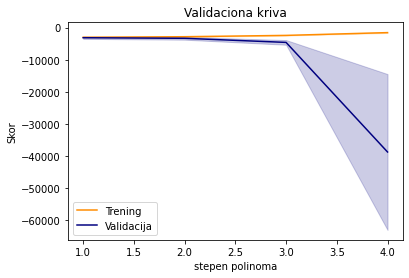

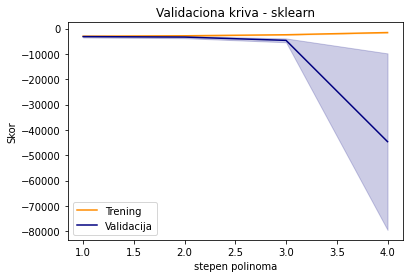

In [20]:
cross_validation_poly_plot(X_train, y_train, max_degree=4, folds=5, bias=False)

Vidimo da je situacija jako loša za polinom četvrtog reda (prema tome, taj red možemo iskoristi kada radimo regularizaciju). Ponovićemo postupak za polinom do trećeg reda da bi se bolje videlo kakvi su rezultati.

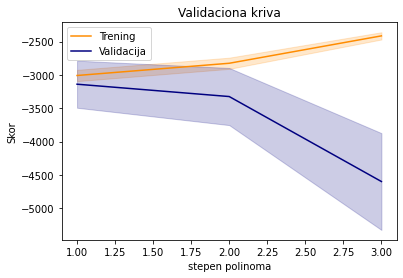

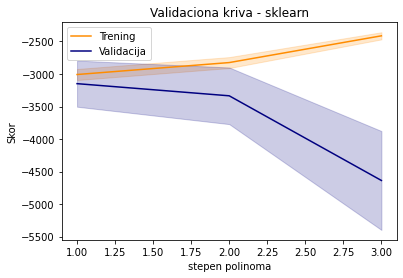

In [21]:
cross_validation_poly_plot(X_train, y_train, max_degree=3, folds=5, bias=False)

Očigledno, red polinoma za koji su rezultati najbolji je jedan, odnosno, najbolje je koristiti običnu linearnu regresiju.

In [22]:
myModel= PolynomialRegressionModel(X_train, y_train, bias=False)
myModel.fit_data(degree=1)
y_predict = myModel.predict(X_test)

print(-mean_squared_error(y_predict, y_test))

-3650.773228847059


In [23]:
print(myModel.theta)

[ 29.20083068 -13.61218951   9.36707509  32.34729844   4.12539692]


In [24]:
print("Srednja vrednost greske: ", (y_test-y_predict).mean())
print("Standardna devijacija greske: ", (y_test-y_predict).std())

Srednja vrednost greske:  -6.9594556663228495
Standardna devijacija greske:  60.01949021505885


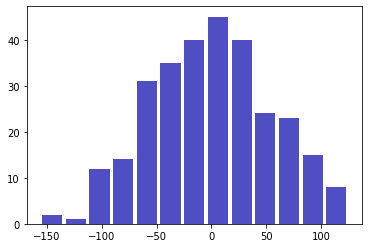

In [25]:
n, bins, patches = plt.hist(x=(y_train-myModel.predict(X_train)), bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)

### 3.3. Zakljucak

Srednja kvadratna greška je dosta slična srednjoj vrednosti srednje kvadratne greške na validacionim skupovima, što znači da nije došlo do preobučavanja, odnosno, naš model radi onako kako predvideli i kada se koriste novi podaci na kojima nije treniran. 

Rečeno je da je korišćena kriterijumska funkcija ekvivalentna korišćenju principa maksimalne verodostojnosti ukoliko se predpostavi da postoji sledeća veza između ulaza i željenih izlaza:

$$y^{(i)}=h_{\theta}(x^{(i)})+ \epsilon^{(i)} $$

gde je $\epsilon^{(i)}$ član koji modeluje šum i eventualna obeležja koja nisu uzeta u obzir, a ima Gausovu raspodelu. 

Na slici iznad je prikazan histogram ove greške (korišćen je test skup jer ima više podataka) i njena raspodela zaista dosta liči na Normalnu raspodelu. Prema tome, možemo da vidimo da je kriterijumska funkcija koju smo koristili u ovom slučaju opravdana. Unakrsna validacija je odredila optimalni red polinoma, a činjenica da je i kriterijumska funkcija razumno izabrana navode na to da, ukoliko bismo bili veoma nezadovoljni rezultatima koje daje model, kao razlog za to bi valjalo razmotriti mogućnost da su neka bitna obeležja izostavljena prilikom prikupljanja podataka. 

## 4. Regularizacija

Ideja regularizacije je da se model kazni kada odredjenim parametrima da prevelike vrednosti. Uvodjenjem regularizacije kriterijumska funkcija postaje:

$$J(\theta)=\sum_{i=1}^{m}(h_{\theta}(x^{(i)})-y^{(i)})^2 + R(\theta)$$

Pre regularizacije je neophodno standardizovati ulaze, u suprotnom regularizacija neće biti fer. Regularizacija sve parametre podjenako kažnjava ako imaju prevelike vrednosti, a vrednosti parametara između ostalog i zavise od toga koje vrednosti uzima obeležje sa kojim rade, pa ako ta obeležja imaju raličite opsege, regularizacija neće biti fer. Kako su podaci standardizovani i centrirani na početku, to ovde nije problem.

### 4.1. Grebena (ridge) regresija

U slucaju grebene regresije, regularizaciona funkcija je data formulom:

$$ R_2(\theta) = \lambda \sum_{i=1}^{n}\theta_i^2$$

Ukoliko su podaci i izlazi centrirani, parametar $\theta_0$ će biti nula, pa se može izbaciti iz kriterijumske funkcije koja se onda lako minimizuje i dobijamo optimalnu vrednost $\theta$ u formi:

$$ \theta^*=(X^TX+\lambda I)^{-1}X^Ty$$

gde se podrazumeva da $X$ i $y$ odgovaraju centriranim ulazima i izlazima.

Određivanje parametra $\lambda$ se može odrediti tako što se pretpostavi da je $\lambda=0$ nula i potom povećava red polinoma dok ne dođe do očiglednog preobučavanja. Uzima se taj red polinoma i potom radi unakrsna validacija sa različitim vrednostima $\lambda$ parametra. 

Gore smo videli da se preobučavanje dešava kada koristimo polinom 4. reda, prema tome, to će da bude i red polinoma sa kojim radimo grebenu regresiju. Dole je data klasa polinomijalnog modela koja je modifikovana tako da koristi ridge regresiju.

In [28]:
from sklearn.linear_model import Ridge

class PolynomialRegressionModelRidge:
    
    def __init__(self, X_train, y_train, degree):
        """
        Creates polynomial regression model. By deafult it's a polynomial of order 1.
        """
        self.y = y_train.copy()

        self.poly_transform = PolynomialFitTransform(X_train, bias=False)
        self.poly_transform.set_degree(degree)
        self.theta = None
        self.degree = degree
        self.alpha = None
    
    def fit_data(self, alpha, degree=None):
        """
        One can change degree when making a fit, or use the one which it was created with. 
        """
        if (degree is not None):
            self.degree = degree
        self.alpha = alpha
        self.poly_transform.set_degree(self.degree)
        X = self.poly_transform.X_
        
        self.theta = np.linalg.inv(X.T @ X + alpha * np.identity(X.shape[1])) @ X.T @ self.y
        
        #Compare with libary function.
        clf = Ridge(alpha=alpha, solver='cholesky', fit_intercept=False)
        clf.fit(X, y_train)
        assert np.allclose(self.theta, clf.coef_)
        
        return self.theta
        
    def predict(self, X_test):
        
        poly = PolynomialFitTransform(X_test)
        poly.set_degree(self.degree) # transform X_test to the matrix needed for current degree used.
        
        y_pred = poly.X_ @ self.theta
        
        return y_pred
    
    def cross_validation_alpha_step(self, folds=5):
        
        train_score = np.zeros((1, folds))
        test_score = np.zeros((1, folds))

        kf = KFold(n_splits=folds)
        kf.get_n_splits(self.poly_transform.X_)

        cur_fold = 0
        for train_index, test_index in kf.split(self.poly_transform.X_):     

            X_train, X_test = self.poly_transform.X_[train_index], self.poly_transform.X_[test_index]
            y_train, y_test = self.y[train_index], self.y[test_index]     
            
            X = X_train
            theta = np.linalg.inv(X.T @ X + self.alpha * np.identity(X.shape[1])) @ X.T @ y_train
            
            # Compare with libarary function.
            clf = Ridge(alpha=self.alpha, solver='cholesky', fit_intercept=False)
            clf.fit(X, y_train)
            assert np.allclose(theta, clf.coef_)
            
            y_pred_test = X_test @ theta
            y_pred_train = X_train @ theta

            test_score[:,cur_fold] = -mean_squared_error(y_test, y_pred_test)
            train_score[:,cur_fold] = -mean_squared_error(y_train, y_pred_train)

            cur_fold +=1

        return train_score, test_score
    
    def cross_validation_alpha(self, alphas, folds=5):
        
        train_scores = np.zeros((alphas.shape[0], folds))
        test_scores = np.zeros((alphas.shape[0], folds))
        
        for i, alpha in enumerate(alphas):
            self.alpha = alpha
            train_score, test_score = self.cross_validation_alpha_step(folds) 
            train_scores[[i],:] = train_score
            test_scores[[i],:] = test_score
            
        return train_scores, test_scores

In [29]:
myModel= PolynomialRegressionModelRidge(X_train, y_train, 4)
y=myModel.fit_data(0.01, degree=5)

In [30]:
from sklearn.model_selection import cross_val_score

def cross_validation_alpha_plot(X_train, y_train, alphas, degree, folds):
    
    myModel= PolynomialRegressionModelRidge(X_train, y_train, degree)
    
    _, test_scores = myModel.cross_validation_alpha(alphas, folds=folds)
    
    test_scores_mean = np.mean(test_scores, axis=1)

    plt.title("Validaciona kriva")
    plt.xlabel("Lambda")
    plt.ylabel("Skor")
    lw = 2
    plt.plot(alphas, test_scores_mean, label="Trening",
                color="darkorange")
    plt.show()
    
    # Compare with built-in function.
    X_ = PolynomialFeatures(degree=degree, include_bias=False).fit_transform(X_train)
    model = Ridge(fit_intercept=False, solver='cholesky')
    _, test_scores_sk = validation_curve(
                        model, X_, y_train,
                        param_name='alpha',
                        param_range=alphas,
                        cv=folds,
                        scoring='neg_mean_squared_error')
        
    plt.title("Validaciona kriva - sklearn")
    plt.xlabel("Lambda")
    plt.ylabel("Skor")
    lw = 2
    
    test_scores_mean = np.mean(test_scores_sk, axis=1)
    
    plt.plot(alphas, test_scores_mean, label="Trening",
                color="navy")
    plt.show()

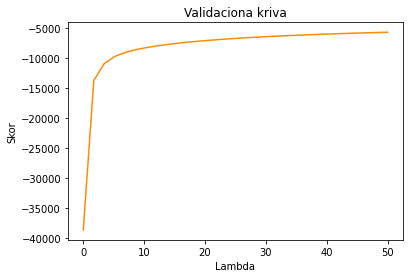

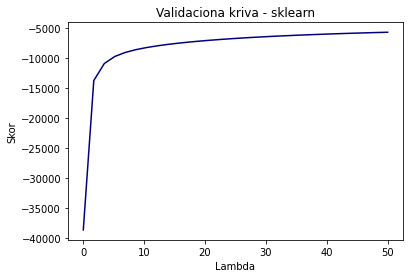

In [31]:
alphas = np.linspace(1e-3, 50, 30)
cross_validation_alpha_plot(X_train, y_train, alphas, degree=4, folds=5)

Vidmo da za $\lambda$ veće od 20 nema značajnog poboljšavanja rezultata, pa ćemo proveriti kako se model za tu vrednost $\lambda$ ponaša na validacionom skupu.

In [32]:
myModel= PolynomialRegressionModelRidge(X_train, y_train, degree=4)
myModel.fit_data(alpha=20)
y_pred = myModel.predict(X_test)

print(-mean_squared_error(y_predict, y_test))

-3650.773228847059


In [33]:
print(myModel.theta)

[ 2.60235515e+01 -5.68224374e+00  1.01989190e+01  2.33764405e+01
  4.09556585e+00  9.68717618e-01 -2.90825665e+00  2.57904967e+00
  5.79953497e+00  5.56763540e+00 -5.89808434e+00  6.36086930e-01
 -1.10796562e+01 -3.31110335e+00 -2.52966168e+00 -9.12941135e+00
 -2.58754455e-01  3.44058645e+00 -5.00601923e+00  4.56142802e+00
  9.96085628e-01 -8.39414408e-01  2.17115421e-01  3.67189595e+00
 -2.15152315e-01  2.56000578e+00 -1.00066239e+01  4.80507040e+00
 -2.07559195e+00 -6.93859687e+00 -4.14323623e+00  1.50804804e+00
  3.77467295e+00  4.77180716e+00 -2.05114307e+00  1.00706711e-01
 -4.91961317e+00  3.30063773e+00 -1.03203971e+00 -3.88138943e+00
  5.59490622e+00 -3.28782550e+00 -1.80912409e+00 -2.65604603e+00
  7.34603165e-01  7.06143090e+00 -2.81066909e-01  2.30729610e+00
  1.73081177e+00 -4.31247271e+00  3.45888278e+00  6.26977236e-01
 -7.41444589e+00  7.26289286e+00 -1.78043557e+00  3.02457889e-01
 -1.95853723e+00 -3.93768780e+00 -1.39742519e+00  1.74391666e+00
  1.17754969e+00  2.39758

In [34]:
print("Srednja vrednost greske: ", (y_test-y_predict).mean())
print("Standardna devijacija greske: ", (y_test-y_predict).std())

Srednja vrednost greske:  -6.9594556663228495
Standardna devijacija greske:  60.01949021505885


### 4.1.1. Zaključak

Greška koju dobijamo na validacionom skupu kada koristimo grebenu regresiju je praktično ista kao ona koja se dobija kada koristimo običnu linearnu regresiju. Nije došlo do poboljšanja modela, ali je kompleksnost modela, to jest broj parametara, značajno povećana. U ovom slučaju prednost definitivno ima obična linearna regresija. 

### 4.2. Lasso regularizacija

Laso regularizacija je definisana regularizacionom funkcijom:

$$ R_1(\theta) = \lambda \sum_{i=1}^{n}|\theta_i| $$

Korisenje LASSO regularizacije je je ekvivalentno minimizacji kriterijumske funkcije pod uslovom $ \lambda \sum_{i=1}^{n}|\theta_i| < t$. Zbog toga je veća verovatnoća da će se pojedine komponente vektora $\theta$ postaviti na nulu prilikom minimizacije nego kod grebene regresije. 

Mana ove regularizacije je u tome što je kriterijumska funkcija uvođenjem LASSO regularizacije postala nediferencijabilna, pa se samim tim ne moze naći rešenje u zatvorenoj formi. Zbog toga što funkcija nije diferencijabilna ne može se ni koristiti neka vrsta gradijentnog spusta za minimizaciju, ali je moguće koristiti koordinatni spust ili LASSO algoritam. Koordinatni spust se pokazuje kao brže resenje, a ujedno je i mnogo jednostavnije za implementaciju, osim toga, ovaj algoritam se koristi i u bibliotečnoj funkciji što olakšava proveru, pa će zbog toga biti korišćeno ovde.

Ako je funkcija $f(x)=g(x)+\sum_{i}h_i(x_i)$ i ako je $g(x)$ konveksna i diferencijabilna i svako $h_i$ konveksno, tada se metodom koordinatnog spusta moze pronaci $\min f(x)$ po $x$. 

Koordinatni spust se radi tako sto se funkcija minimizuje po svakoj komponenti posebno:

$$x_i^{(k)} = \text{argmin}_{x_i} f(x_1^{(k)},...,x_{i-1}^{(k)}; x_i; x_{i+1}^{(k-1)},..., x_n^{(k-1)}$$

U slučaju linearne regresije imamo:

$$J(\theta)=(X\theta-y)^T(X\theta-y)+\lambda\sum_{i=1}^{n}\theta_i$$

Ako gornji izraz promenimo tako što izvučemo delove koji sadrže $\theta_i$ tako da je $\theta$ vektor $\theta$ gde je $i$-ta komponenta postavljena na nulu i sa $X_i$ označimo $i$-tu kolonu matrice $X$, kriterijumsku funkciju možemo da pišemo:

$$ J(\theta)=(X\theta+X_i\theta_i-y)^T(X\theta + X_i\theta_i-y)+\lambda\sum_{j=1,j \neq i}^{n}|\theta_j| + \lambda|\theta_i|$$

Sređivanjem ovog izraza dobijamo:

$$ J(\theta)=\theta_iX_i^TX\theta+\theta_i^2X_i^TX_i-\theta_iX_i^Ty+\theta_i\theta^TX^TX_i-\theta_iy^TX_i + \lambda s_i\theta_i + C $$

gde smo u konstantu $C$ smestili sve one članove koji ne zavise od $\theta_i$, a $s_i$ uzima vrednosti $-1,1$.

Odavde možemo da nađemo izvod po $\theta_i$:

$$ \frac{\partial J}{\partial \theta_i}=X_i^TX\theta+2\theta_iX_i^TX_i-X_i^Ty+\theta^TX^TX_i-y^TX_i+\lambda s_i $$

Dobijeni rezultat je skalar, kao i svi članovi zbira, pa se svaki član moze transponovati. Na ovaj način se izraz uprošćava i dobija se:

$$ \frac{\partial J}{\partial \theta_i}=X_i^TX\theta+\theta_iX_i^TX_i-X_i^Ty+\lambda s_i $$

pri tome je dvojka smestena u $\lambda$. 

Diferenciranje apsolutne vrednosti daje:

$$ \theta_i = - \frac{X_i^T(X\theta-y)+\lambda}{X_i^TX_i} , X_i^T(X\theta-y) < -\lambda$$
$$ \theta_i = - \frac{X_i^T(X\theta-y)-\lambda}{X_i^TX_i}, X_i^T(X\theta-y) > \lambda$$
$$ \theta_i = 0, -\lambda \leq X_i^T(X\theta-y) \leq \lambda$$

In [35]:
from sklearn.linear_model import Lasso

def J(X, theta, y, alpha):
    return np.dot(X @ theta - y, X @ theta - y) + alpha * sum(abs(theta))

def coordinate_descent(X, y, alpha, eps=1e-5):
    
    theta = np.random.random(X.shape[1])
    num_of_iterations = 0
    
    while True:
        i = num_of_iterations % X.shape[1]
        theta_ = np.concatenate([theta[:i], [0], theta[i+1:]])
        Xi = X[:,i]      
        
        ro = Xi.T @ (X @ theta_ - y)
        
        if (ro < -alpha):
            new_theta_i = - ( ro + alpha) / (Xi.T @ Xi)
        elif ro > - alpha:
            new_theta_i = - ( ro - alpha) / (Xi.T @ Xi)
        else:
            new_theta_i = 0
        
        new_theta = np.concatenate([theta[:i], [new_theta_i], theta[i+1:]])
        
        delta_J = abs(J(X, theta, y, alpha) - J(X, new_theta, y, alpha))
        if (delta_J < eps and i == X.shape[1] - 1):
            return new_theta
        
        theta = new_theta
        num_of_iterations += 1
        if (num_of_iterations > 5000):
            print("Warning, did not converge after 5000 steps")
            return theta
    

Datu implementaciju možemo da uporedimo sa gotovom implementacijom iz *sklearn* biblioteke. 

In [36]:
poly_transform = PolynomialFitTransform(X_train, bias=False)
poly_transform.set_degree(3)
X_ = poly_transform.X_

eps = 1e-4

theta = coordinate_descent(X_, y_train, alpha=0.1, eps=eps)
print(theta)

clf = Lasso(alpha=0.1, fit_intercept=False, max_iter=5000)
clf.fit(X_, y_train)
print(clf.coef_)

Warning, did not converge after 5000 steps
[ 34.96889657 -13.12723305  15.57829113  41.47435891  -1.36144236
  -1.52025866  -5.51416652   3.57705664  13.13177617  -2.08521543
  -1.10178833  -7.0099673    6.61934534   4.74744006  -5.33732085
   2.04797075   1.9182201   -2.11297844  -5.88150566   3.00186526
   0.63998647  -7.20179555  -4.34916219  -1.97442245   3.65496368
   2.61608196 -16.81015145  26.60261861  -1.63494329  -0.78595922
  -2.00102147   3.38235021  -5.60298803   0.54661686  -4.67410753
   3.3130697   -9.67054262  -4.48023699   0.57665421   1.15644367
  12.53233278   6.25218255  -1.40449396  -8.10933402  -2.84687769
   2.6582522   -1.44385149   4.49302034   3.64389869  -7.6793183
  -2.22123757  -4.09434026  -3.66876268   9.81224723   0.25892434]
[ 33.01450417 -13.7548363   12.7668118   42.90496663   0.
  -0.94961697  -4.55814367   2.83111535  11.61396175  -1.74563285
  -1.2546809   -5.29800716   5.30391125   4.10000841  -6.10837541
   2.67046097   1.52071674  -1.79168163  

Vidimo da implementirana funkcija daje dosta slične rezultate kao i funkcija iz biblioteke. Ipak, pošto razlika ipak postoji, da bi dalje moglo bez problema da se poredi rezultat sa gotovim, iskoristićemo funkciju iz biblioteke za nalaženje optimalne vrednosti parametra $\lambda$.

In [37]:
def cross_validate_LASSO_step(X_, y, alpha, folds):
        
        train_score = np.zeros((1, folds))
        test_score = np.zeros((1, folds))

        kf = KFold(n_splits=folds)
        kf.get_n_splits(X_)

        cur_fold = 0
        for train_index, test_index in kf.split(X_):     

            X_train, X_test = X_[train_index], X_[test_index]
            y_train, y_test = y[train_index], y[test_index]     
            
            clf = Lasso(alpha=alpha, fit_intercept=False, max_iter=7000)
            clf.fit(X_train, y_train)
            theta = clf.coef_
            
            y_pred_test = X_test @ theta
            y_pred_train = X_train @ theta

            test_score[:,cur_fold] = -mean_squared_error(y_test, y_pred_test)
            train_score[:,cur_fold] = -mean_squared_error(y_train, y_pred_train)

            cur_fold +=1

        return train_score, test_score

In [38]:
def cross_validation_LASSO(X_, y_train, alphas, folds):

    train_scores = np.zeros((alphas.shape[0], folds))
    test_scores = np.zeros((alphas.shape[0], folds))

    for i, alpha in enumerate(alphas):
        train_score, test_score = cross_validate_LASSO_step(X_, y_train, alpha, folds)
        train_scores[[i],:] = train_score
        test_scores[[i],:] = test_score

    return train_scores, test_scores

In [39]:
def cross_validation_LASSO_plot(X_train, y_train, alphas, degree, folds):
    
    poly_transform = PolynomialFitTransform(X_train, bias=False)
    poly_transform.set_degree(degree)
    X_ = poly_transform.X_
    
    _, test_scores = cross_validation_LASSO(X_, y_train, alphas, folds)
    
    test_scores_mean = np.mean(test_scores, axis=1)

    plt.title("Validaciona kriva")
    plt.xlabel("Lambda")
    plt.ylabel("Skor")
    lw = 2
    plt.plot(alphas, test_scores_mean, label="Trening",
                color="darkorange")
    plt.show()
    
    # Compare with built-in function.
    X_ = PolynomialFeatures(degree=degree, include_bias=False).fit_transform(X_train)
    model = Lasso(fit_intercept=False)
    _, test_scores_sk = validation_curve(
                        model, X_, y_train,
                        param_name='alpha',
                        param_range=alphas,
                        cv=folds,
                        scoring='neg_mean_squared_error')
        
    plt.title("Validaciona kriva - sklearn")
    plt.xlabel("Lambda")
    plt.ylabel("Skor")
    lw = 2
    
    test_scores_mean = np.mean(test_scores_sk, axis=1)
    
    plt.plot(alphas, test_scores_mean, label="Trening",
                color="navy")
    plt.show()

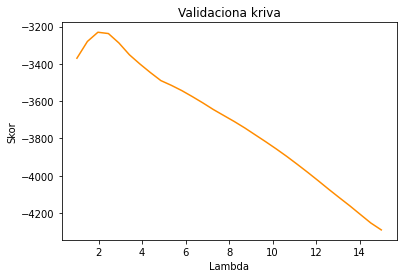

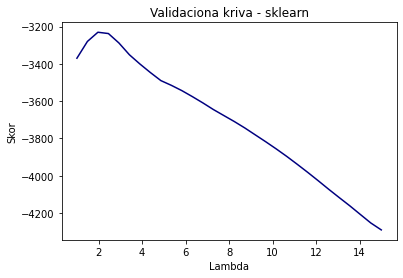

In [44]:
alphas = np.linspace(1, 15, 30)
cross_validation_LASSO_plot(X_train, y_train, alphas, degree=3, folds=5)

Izabran je polinom trećeg stepena jer algoritam ima problem sa konvergencijom za više redove. Sa grafika se vidi da je optimalna vrednost hiper-parametra oko 2.5. Proverićemo kako se model ponaša sa ovim hiper-parametrom na validacionom skupu.

In [46]:
poly_transform = PolynomialFitTransform(X_train, bias=False)
poly_transform.set_degree(3)
X_ = poly_transform.X_

clf = Lasso(alpha=2.5, fit_intercept=False, max_iter=7000)
clf.fit(X_, y_train)
theta = clf.coef_

poly_transform = PolynomialFitTransform(X_test, bias=False)
poly_transform.set_degree(3)
X_ = poly_transform.X_

y_predict = X_ @ theta

print(-mean_squared_error(y_predict, y_test))
print("Srednja vrednost greske: ", (y_test-y_predict).mean())
print("Standardna devijacija greske: ", (y_test-y_predict).std())
print(theta)

-4188.610311285477
Srednja vrednost greske:  -10.932329865463876
Standardna devijacija greske:  63.789454261642376
[27.14025047 -0.          1.28237279 33.77707629  0.          0.
  0.          0.          0.          0.         -0.38787069 -0.
  0.          0.         -1.8023507  -0.          0.         -0.
 -0.          2.49005068  0.36750642 -3.32664168 -0.          0.
  0.59169594  0.         -0.2121583   0.         -0.         -0.
 -0.         -0.          0.         -0.          0.          0.
 -0.          0.         -0.         -6.54067354  0.         -0.
 -0.         -0.         -0.          3.41527895  2.99490371  1.34004383
  0.         -0.          0.         -2.25782661 -0.3233933   0.
  0.81621178]


### 4.2.1. Zaključak

LASSO model je dao malo gore rezultate nego prethodna dva modela. Kao što je očekivano, većina obeležja se ne uzima u obzir. Vidimo da je situacija dosta slična običnoj linearnoj regresiji, prvi i četvrti parametar imaju skoro iste vrednosti i one su za red veličina veće od svih drugih. Dakle, ova dva obeležja su ta koja najviše utiču na izlaz.  

## 5. Lokalno ponderisana linearna regresija ##

Linearno ponderisana linearna regresija se bazira na tome da se pronadje najbolji model za onu tacku u kojoj pokusava da se nadje izlaz. U toj tački se model formira minimizacijom funkcije

$$J(\theta)=\sum_{i=1}^{m}w^{(i)}(h_{\theta}(x^{(i)})-y^{(i)})^2$$

Pri tome je funkcija težine definisana kao:

$$ w^{(i)}=\exp \left(-\frac{(x-x^{(i)})^T(x-x^{(i)})}{2\tau^2}\right)$$

Ukoliko uvedemo dijagonalnu matricu $D$ na čijoj dijagonali se nalaze težine $w^{(1)},x^{(2)}, ... ,w^{(m)}$ a van nje nule, kriterijumska funkcija se može zapisati kao:

$$J(\theta) = (X\theta-y)^TD(X\theta-y)$$

Koričćenjem činjenice da je

$$\frac{\partial (Ax+b)^TC(Dx+e)}{\partial x}=D^TC^T(Ax+b)+A^TC(Dx+e)$$

dobijamo izvod kriterijumske funkcije po parametru $\theta$

$$ \frac{\partial J(\theta)}{\partial \theta}=X^TD^T(X\theta-y)+X^TD(X\theta-y)$$

Kada gornji izraz sredimo (matrica $D$ je simetricna) i izjednačimo sa nulom dobijamo:

$$X^TD(X\theta-y)=0$$

Odavde dobijamo optimalno $\theta$ u zatvorenoj formi:

$$\theta^*=(X^TDX)^{-1}X^TDy$$

Kada nađemo optimalnu vrednost $\theta$ u tački $x$ tada možemo predvideti vrednost izlazne promenljive u toj tački na osnovu hipoteze. 

Glavna razlika između lokalno ponderisane linearne regresije i obične polinomijalne regresije je u tome što u drugom slučaju, onog trenutka kada napravimo dovoljno dobar model, mozemo da "zaboravimo" na podatke koji su korišćeni za obučavanje modela, oni prosto nisu neophodni za predviđanje izlaza. U slučaju lokalno ponderisane linearne regresije, za svaku predikciju su potrebni podaci iz obucavajuceg skupa, cak i onda kada smo našli zadovoljavajuci model (model je prakticno samo vrednost $\tau$ parametra).

Hiper-prarametar modela ćemo takođe odrediti korišćenjem unakrsne validacije. Ispod je data klasa koja implementira lokalno ponderisanu linearnu regresiju.

In [47]:
def add_ones(X_train):
    X0 = np.ones((X_train.shape[0],1))
    X_train_new = np.hstack((X0, X_train))
    
    return X_train_new

class LocallyWeightedLinearRegression:
    def __init__(self, X_train, y_train, x_test, y_test, tau):
        
        self.X = add_ones(X_train)
        self.y = y_train.copy()
        
        self.X_pred = add_ones(x_test)
        self.y_test = y_test.copy()
        self.y_pred = np.zeros_like(y_test)
        
        self.tau = tau
        
    def weights(self, x): # x row vector!
        w = np.exp(-(np.linalg.norm(x-self.X, axis=1)**2)/(2*self.tau**2))
        D = np.diag(w)
        return D
    
    def model_at(self, x): 
        D = self.weights(x)
        theta = np.linalg.inv(self.X.T @ D @ self.X) @ self.X.T @ D @ self.y 
        y = x @ theta
        return y
    
    def predictions_test(self):
        for i in range(0, self.X_pred.shape[0]):
            self.y_pred[i] = self.model_at(self.X_pred[[i],:])
        return self.y_pred
    
    def predictions_train(self):
        y_pred_train = np.zeros_like(self.y)
        for i in range(0, self.X.shape[0]):
            y_pred_train[i] = self.model_at(self.X[[i],:])
        return y_pred_train
    
    def scores(self):      
        y_pred_test = self.predictions_test()
        y_pred_train = self.predictions_train()
        
        train_score = -mean_squared_error(self.y, y_pred_train)
        test_score = -mean_squared_error(self.y_test, y_pred_test)
        
        return train_score, test_score

In [48]:
def LWLR_cross_validation_step(X, y, tau, folds):
    
    train_scores = np.zeros((1, folds))
    test_scores = np.zeros((1, folds))

    kf = KFold(n_splits=folds)
    kf.get_n_splits(X)

    cur_fold = 0
    for train_index, test_index in kf.split(X):     

        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]     

        lwlr = LocallyWeightedLinearRegression(X_train, y_train, X_test, y_test, tau)

        train_scores[:,cur_fold], test_scores[:, cur_fold] = lwlr.scores()

        cur_fold +=1

    return train_scores, test_scores

In [49]:
def LWLR_cross_validation(X, y, tau_range, folds):
                          
    train_scores = np.zeros((tau_range.shape[0], folds))
    test_scores = np.zeros((tau_range.shape[0], folds))

    for i,tau in enumerate(tau_range):
        train_score, test_score = LWLR_cross_validation_step(X, y, tau, folds) 
        train_scores[[i],:] = train_score
        test_scores[[i],:] = test_score

    return train_scores, test_scores

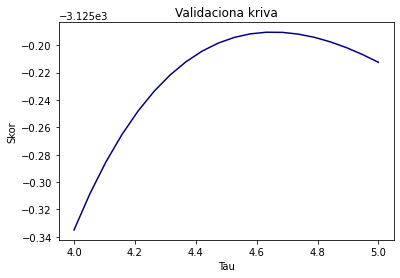

In [52]:

tau_range=np.linspace(4, 5, 20)
train_scores, test_scores = LWLR_cross_validation(X_train, y_train, tau_range, 10)

test_scores_mean = np.mean(test_scores, axis=1)

plt.title("Validaciona kriva")
plt.xlabel("Tau")
plt.ylabel("Skor")
lw = 2
plt.plot(tau_range, test_scores_mean, label="Validacija",
             color="navy")
plt.show()

Optimalna vrednost hiper-parametra je 4.6. Sada možemo da proverimo kako se model ponaša na validacionom skupu podataka.

In [51]:
lwlr = LocallyWeightedLinearRegression(X_train, y_train, X_test, y_test, tau=4.6)
print(lwlr.scores())

(-2992.1165246350542, -3640.481544333387)


### 5.1. Zaključak

Naš model na validacionom skupu daje gotovo istu grešku kao i obična linearna regresija. Ponovo, kada se uzme u obzir kompleksnost modela, kao najbolje rešenje se izdvaja obična linearna regresija. Velika prednost lokalno ponderisane linearne regresije je u tome što vrlo jednostavno može da modeluje situacije u kojima dobra aproksmacija nije matematička funkcija u zatvorenoj formi, mada je ovo ujedno i njena mana jer nam samim tim i otežava da razumemo dobijeni rezultat. 

## 6. Zaključak

U ovom domaćem zadatku je prikazano nekolko vrsta linearne regresije - obična, odnosno polinomijalna regresija, sa i bez regularizacije kao i lokalno ponderisana linearna regresija. Implementacija funkcija je urađena po ugledu na gotove funkcije iz biblioteka i cilj implementacije je bio prikazati kako rade objašnjeni algoritmi.

Ispostavilo se da je najbolja aproksimacija, kada se uzme u obzir da model treba da bude što jednostavniji, ipak obična linearna regresija. Druga rešenja su dala približno iste rezultate na validacionom skupu, a činjenica da je greška na validacionom i obučavajućem skupu dovoljno slična, dokazuje da model nije preobučen. 

Greška koju pravimo na validacionom skupu ima dosta veliku standardnu devijaciju, a njena ozbiljnost zavisi, između ostalog, i od toga šta pokušavamo da modelujemo, odnosno šta predstavljaju ti podaci. U ovom kontekstu je teško reći da li je to dovoljno dobar rezultat ili ne, jedino što može da se kaže je da je izlaz bolje predviđen nego što bi bio slučaj da nismo imali date ulaze, to jest, da smo izlaz modelovali kao slučajnu promenljivu.

To što smo dobili slične rezultate ukazuje da, ukoliko nismo zadovoljni ponašanjem modela, odnosno smatramo da nije dovoljno tačan, treba da razmotrimo neki drugi pristup, to jest, iz datih podataka su uzete informacije koje su mogle biti dobijene linearnom regresijom i dodatne optimizacije ne mogu da nadoknade ono što ne postoji u samim podacima. 

Ovo opet zavisi od toga šta predstavljaju ovi podaci; da li ima smisla razmatrati ideju da možda nismo uzeli sva bitna obeležja, da li su merenja takva da se pojavljuje puno šuma, koliko nam je dozvoljena greška, da li je moguće prikupiti još podataka i ponoviti postupak i slično. 

